In [2]:
import pandas as pd
import numpy as np
import urllib.parse

# Define the ExtractFeatures function
def ExtractFeatures(path, body):
    path = str(path)
    body = str(body)
    combined_raw = path + body
    raw_percentages = combined_raw.count("%")
    raw_spaces = combined_raw.count(" ")

    raw_percentages_count = raw_percentages if raw_percentages > 3 else 0
    raw_spaces_count = raw_spaces if raw_spaces > 3 else 0

    path_decoded = urllib.parse.unquote_plus(path)
    body_decoded = urllib.parse.unquote_plus(body)

    single_q = path_decoded.count("'") + body_decoded.count("'")
    double_q = path_decoded.count("\"") + body_decoded.count("\"")
    dashes = path_decoded.count("--") + body_decoded.count("--")
    braces = path_decoded.count("(") + body_decoded.count("(")
    spaces = path_decoded.count(" ") + body_decoded.count(" ")
    semicolons = path_decoded.count(";") + body_decoded.count(";")
    angle_brackets = path_decoded.count("<") + path_decoded.count(">") + body_decoded.count("<") + body_decoded.count(">")
    special_chars = sum(path_decoded.count(c) + body_decoded.count(c) for c in '$&|')

    badwords_count = sum(path_decoded.lower().count(word) + body_decoded.lower().count(word) for word in badwords)

    path_length = len(path_decoded)
    body_length = len(body_decoded)

    return [single_q, double_q, dashes, braces, spaces, raw_percentages_count, semicolons, angle_brackets, special_chars, path_length, body_length, badwords_count]

# List of bad words to check in the URL path
badwords = ['sleep', 'uid', 'select', 'waitfor', 'delay', 'system', 'union', 'order by', 'group by', 'admin', 'drop', 'script']

# Load dataset
http = pd.read_csv(r'C:\Users\Rudra kumar\Desktop\`\project\Python proj\New folder (2)\merged_data.csv')

# Handle missing values
http['path'].fillna('', inplace=True)
http['body'].fillna('', inplace=True)

# Extract features
http['features'] = http.apply(lambda row: ExtractFeatures(row['path'], row['body']), axis=1)

# Prepare data for training
X = np.array(http['features'].tolist())
y = http['class'].values

# Display the first few rows with features
print(http[['path', 'body', 'features']].head())

                                                path  \
0                                           /doLogin   
1                                      /sendFeedback   
2                                 /admin/clients.xls   
3  /my%20documents/JohnSmith/Bank%20Site%20Docume...   
4  /my%20documents/JohnSmith/Bank%20Site%20Docume...   

                                                body  \
0                  uid=ZAP&passw=ZAP&btnSubmit=Login   
1  cfile=comments.txt&name=ZAP&email_addr=ZAP&sub...   
2                                                      
3                                                      
4                                                      

                                  features  
0    [0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 33, 1]  
1  [0, 0, 0, 0, 7, 0, 0, 0, 5, 13, 124, 0]  
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 1]  
3    [0, 0, 0, 0, 3, 0, 0, 0, 0, 57, 0, 0]  
4    [0, 0, 0, 0, 3, 0, 0, 0, 0, 82, 0, 0]  


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
import pickle

# Feature extraction function
def ExtractFeatures(path, body):
    path = str(path)
    body = str(body)
    combined_raw = path + body
    raw_percentages = combined_raw.count("%")
    raw_spaces = combined_raw.count(" ")

    raw_percentages_count = raw_percentages if raw_percentages > 3 else 0
    raw_spaces_count = raw_spaces if raw_spaces > 3 else 0

    path_decoded = urllib.parse.unquote_plus(path)
    body_decoded = urllib.parse.unquote_plus(body)

    single_q = path_decoded.count("'") + body_decoded.count("'")
    double_q = path_decoded.count("\"") + body_decoded.count("\"")
    dashes = path_decoded.count("--") + body_decoded.count("--")
    braces = path_decoded.count("(") + body_decoded.count("(")
    spaces = path_decoded.count(" ") + body_decoded.count(" ")
    semicolons = path_decoded.count(";") + body_decoded.count(";")
    angle_brackets = path_decoded.count("<") + path_decoded.count(">") + body_decoded.count("<") + body_decoded.count(">")
    special_chars = sum(path_decoded.count(c) + body_decoded.count(c) for c in '$&|')

    badwords_count = sum(path_decoded.lower().count(word) + body_decoded.lower().count(word) for word in badwords)

    path_length = len(path_decoded)
    body_length = len(body_decoded)

    return [single_q, double_q, dashes, braces, spaces, raw_percentages_count, semicolons, angle_brackets, special_chars, path_length, body_length, badwords_count]

# List of bad words
badwords = ['sleep', 'uid', 'select', 'waitfor', 'delay', 'system', 'union', 'order by', 'group by', 'admin', 'drop', 'script']

# Function to evaluate models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
        recall = recall_score(y_test, y_pred, average='weighted')        # Use 'weighted' for multi-class
        f1 = f1_score(y_test, y_pred, average='weighted')                # Use 'weighted' for multi-class
        
        # Store results
        results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    return results
# Function to save the best model
def save_best_model(results, models, scaler, label_encoder, base_path='best_model'):
    best_accuracy = 0
    best_model_name = None

    # Find the best model
    for model_name, model_results in results.items():
        if model_results['accuracy'] > best_accuracy:
            best_accuracy = model_results['accuracy']
            best_model_name = model_name

    print(f"\nBest Model: {best_model_name} (Accuracy: {best_accuracy:.4f})")

    # Save the best model
    best_model = models[best_model_name]
    with open(f'{base_path}_best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)

    # Save the scaler
    with open(f'{base_path}_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # Save the label encoder
    with open(f'{base_path}_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)

    print(f"Best model, scaler, and encoder saved to {base_path}_*.pkl")
    return best_model_name

# Main block
if __name__ == "__main__":
    # Load your dataset
    http = pd.read_csv('all_datas_f.csv')
    
    # Handle missing values in the body column
    http['body'].fillna('', inplace=True)
    
    # Extract features
    http['features'] = http.apply(lambda row: ExtractFeatures(row['path'], row['body']), axis=1)
    X = np.array(http['features'].tolist())
    y = http['class'].values
    
    # Print class distribution before splitting
    print("\nClass Distribution Before Splitting:")
    print(pd.Series(y).value_counts())
    
    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    # Encode the target variable
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Define models
    models = {
        'logistic': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'random_forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'gradient_boost': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'svm': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
        'adaboost': AdaBoostClassifier(n_estimators=100, random_state=42),
        'xgboost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'lightgbm': LGBMClassifier(random_state=42)
    }
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Evaluate models
    results = evaluate_models(models, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded)
    
    print("\n=== Final Comparison ===")
    for model_name, model_results in results.items():
        print(f"{model_name} Accuracy: {model_results['accuracy']:.4f}")
        print(f"{model_name} Precision: {model_results['precision']:.4f}")
        print(f"{model_name} Recall: {model_results['recall']:.4f}")
        print(f"{model_name} F1-Score: {model_results['f1_score']:.4f}")
    # Save the best model
    best_model_name = save_best_model(results, models, scaler, label_encoder, base_path='ensemble_waf')
    
    # Load the best model for predictions
    with open('ensemble_waf_best_model.pkl', 'rb') as f:
        best_model = pickle.load(f)
    with open('ensemble_waf_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    with open('ensemble_waf_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    
    print(f"\nLoaded model, scaler, and encoder from ensemble_waf_*.pkl")

    # Test a prediction
    sample = X_test[0].reshape(1, -1)
    sample_scaled = scaler.transform(sample)
    predicted_class = label_encoder.inverse_transform(best_model.predict(sample_scaled))
    print(f"\nPredicted class for the sample: {predicted_class}")


Class Distribution Before Splitting:
0    287
1    235
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 164, number of negative: 201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 365, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449315 -> initscore=-0.203438
[LightGBM] [Info] Start training from score -0.203438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


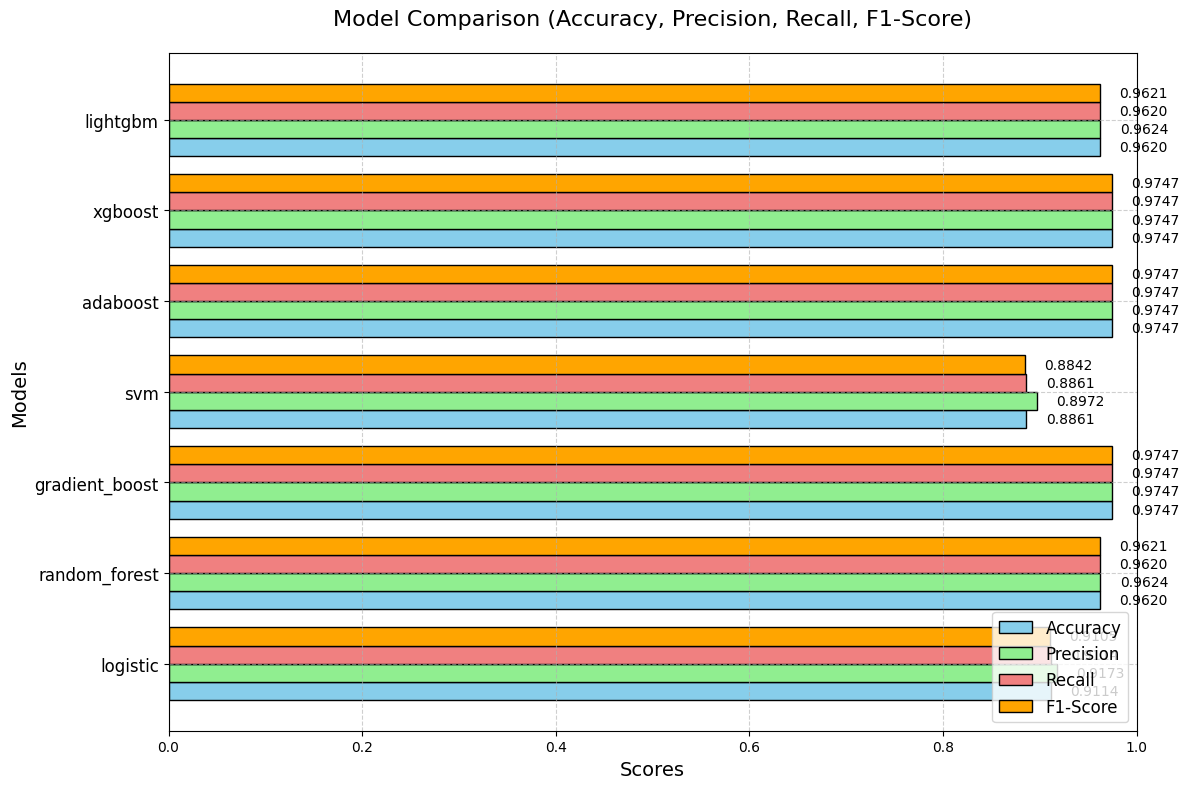

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(results):
    # Extract model names and their metrics
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    precisions = [results[name]['precision'] for name in model_names]
    recalls = [results[name]['recall'] for name in model_names]
    f1_scores = [results[name]['f1_score'] for name in model_names]

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set the height of the bars
    bar_height = 0.2
    index = np.arange(len(model_names))

    # Plot horizontal bars for each metric
    bar1 = ax.barh(index - bar_height, accuracies, bar_height, label='Accuracy', color='skyblue', edgecolor='black')
    bar2 = ax.barh(index, precisions, bar_height, label='Precision', color='lightgreen', edgecolor='black')
    bar3 = ax.barh(index + bar_height, recalls, bar_height, label='Recall', color='lightcoral', edgecolor='black')
    bar4 = ax.barh(index + 2 * bar_height, f1_scores, bar_height, label='F1-Score', color='orange', edgecolor='black')

    # Add labels and title
    ax.set_xlabel('Scores', fontsize=14)
    ax.set_ylabel('Models', fontsize=14)
    ax.set_title('Model Comparison (Accuracy, Precision, Recall, F1-Score)', fontsize=16, pad=20)
    ax.set_yticks(index + bar_height / 2)
    ax.set_yticklabels(model_names, fontsize=12)
    ax.set_xlim(0, 1)  # Set x-axis limit between 0 and 1
    ax.grid(True, linestyle='--', alpha=0.6)  # Add grid lines
    ax.legend(fontsize=12, loc='lower right')  # Add legend

    # Add values on top of each bar
    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.02, bar.get_y() + bar.get_height() / 2, f'{width:.4f}',
                    ha='left', va='center', fontsize=10)

    add_values(bar1)
    add_values(bar2)
    add_values(bar3)
    add_values(bar4)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Visualize model comparison
plot_model_comparison(results)

In [5]:
import pandas as pd
import pickle
import numpy as np

# Load the saved model, scaler, and label encoder
with open('ensemble_waf_best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)
with open('ensemble_waf_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('ensemble_waf_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Function to preprocess and extract features
def preprocess_test_data(test_data):
    # Handle missing values in the 'body' column
    test_data['body'].fillna('', inplace=True)
    
    # Extract features
    test_data['features'] = test_data.apply(
        lambda row: ExtractFeatures(row['path'], row['body']), axis=1
    )
    X_test = np.array(test_data['features'].tolist())
    return X_test

# Load the test data
test_data = pd.read_csv(r'C:\Users\Rudra kumar\Desktop\`\project\Python proj\New folder (2)\Testing_data.csv')

# Preprocess the test data
X_test = preprocess_test_data(test_data)

# Scale the test data
X_test_scaled = scaler.transform(X_test)

# Make predictions
predicted_classes = best_model.predict(X_test_scaled)

# Decode the predictions to original class labels
decoded_predictions = label_encoder.inverse_transform(predicted_classes)

# Add predictions to the test data
test_data['Predicted_Class'] = decoded_predictions

# Save the predictions to a CSV file
test_data.to_csv('Test_data_with_predictions.csv', index=False)

print("Predictions saved to 'Test_data_with_predictions.csv'")


Predictions saved to 'Test_data_with_predictions.csv'


In [9]:
from http.server import SimpleHTTPRequestHandler, HTTPServer
import numpy as np
import pickle
import urllib.parse
import logging
import requests

# Logging configuration
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Feature extraction function
def ExtractFeatures(path, body):
    path = str(path)
    body = str(body)
    combined_raw = path + body
    raw_percentages = combined_raw.count("%")
    raw_spaces = combined_raw.count(" ")

    raw_percentages_count = raw_percentages if raw_percentages > 3 else 0
    raw_spaces_count = raw_spaces if raw_spaces > 3 else 0

    path_decoded = urllib.parse.unquote_plus(path)
    body_decoded = urllib.parse.unquote_plus(body)

    single_q = path_decoded.count("'") + body_decoded.count("'")
    double_q = path_decoded.count("\"") + body_decoded.count("\"")
    dashes = path_decoded.count("--") + body_decoded.count("--")
    braces = path_decoded.count("(") + body_decoded.count("(")
    spaces = path_decoded.count(" ") + body_decoded.count(" ")
    semicolons = path_decoded.count(";") + body_decoded.count(";")
    angle_brackets = path_decoded.count("<") + path_decoded.count(">") + body_decoded.count("<") + body_decoded.count(">")
    special_chars = sum(path_decoded.count(c) + body_decoded.count(c) for c in '$&|')

    badwords_count = sum(path_decoded.lower().count(word) + body_decoded.lower().count(word) for word in badwords)

    path_length = len(path_decoded)
    body_length = len(body_decoded)

    return [single_q, double_q, dashes, braces, spaces, raw_percentages_count, semicolons, angle_brackets, special_chars, path_length, body_length, badwords_count]

# List of bad words
badwords = ['sleep', 'uid', 'select', 'waitfor', 'delay', 'system', 'union', 'order by', 'group by', 'admin', 'drop', 'script']

# Load the best model, scaler, and label encoder
def load_best_model(base_path):
    try:
        with open(f'{base_path}_best_model.pkl', 'rb') as f:
            best_model = pickle.load(f)
        with open(f'{base_path}_scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        with open(f'{base_path}_encoder.pkl', 'rb') as f:
            label_encoder = pickle.load(f)
        return best_model, scaler, label_encoder
    except Exception as e:
        logging.error(f"Failed to load best model: {e}")
        raise

# Proxy server class
class EnhancedHTTPProxy(SimpleHTTPRequestHandler):
    best_model = None
    scaler = None
    label_encoder = None

    @classmethod
    def load_best_model(cls, base_path):
        try:
            cls.best_model, cls.scaler, cls.label_encoder = load_best_model(base_path)
            logging.info("Best model, scaler, and label encoder loaded successfully.")
        except Exception as e:
            logging.error(f"Error loading best model: {e}")

    def proxy_request(self, url):
        try:
            # Forward the request to the target server
            response = requests.get(url)
            
            # Send the response back to the client
            self.send_response(response.status_code)
            for header, value in response.headers.items():
                self.send_header(header, value)
            self.end_headers()
            self.wfile.write(response.content)
        except Exception as e:
            logging.error(f"Error in proxy request: {e}")
            self.send_response(500)
            self.end_headers()

    def do_GET(self):
        try:
            parts = self.path.split('/')
            
            if len(parts) > 3:
                path_part = '/'.join(parts[3:])
                body = ""
                live_data = ExtractFeatures(path_part, body)
                live_data = np.array(live_data).reshape(1, -1)

                if EnhancedHTTPProxy.best_model is None:
                    logging.error("Best model not loaded. Cannot predict.")
                else:
                    # Scale the live data
                    live_data_scaled = EnhancedHTTPProxy.scaler.transform(live_data)
                    
                    # Make prediction
                    result = EnhancedHTTPProxy.best_model.predict(live_data_scaled)
                    result_label = EnhancedHTTPProxy.label_encoder.inverse_transform(result)[0]
                    
                    # Log the prediction result
                    if result_label == 1:
                        logging.warning("Bad request detected! Blocking request.")
                        self.send_response(403)
                        self.end_headers()
                        self.wfile.write(b"403 Forbidden: Bad request detected")
                        return
                    else:
                        logging.info("Good request detected. Proceeding.")
                        self.proxy_request('http://' + parts[2] + '/')
                        return

            if len(parts) >= 2:
                self.proxy_request('http://' + parts[2] + '/')
            else:
                super().do_GET()
        except Exception as e:
            logging.error(f"Error in request handling: {e}")
            self.send_response(500)
            self.end_headers()

# Start the proxy server
if __name__ == "__main__":
    base_path = 'ensemble_waf'
    EnhancedHTTPProxy.load_best_model(base_path)

    server_address = ('127.0.0.1', 8080)
    with HTTPServer(server_address, EnhancedHTTPProxy) as httpd:
        logging.info(f"Server listening on http://{server_address[0]}:{server_address[1]}")
        try:
            httpd.serve_forever()
        except KeyboardInterrupt:
            logging.info("Keyboard interrupt received, shutting down.")

2025-01-23 10:58:24,240 - INFO - Best model, scaler, and label encoder loaded successfully.
2025-01-23 10:58:24,240 - INFO - Server listening on http://127.0.0.1:8080
2025-01-23 10:58:28,402 - INFO - Good request detected. Proceeding.
127.0.0.1 - - [23/Jan/2025 10:58:29] "GET http://demo.testfire.net/index.jsp?content=business_insurance.htm HTTP/1.1" 200 -
2025-01-23 10:58:31,119 - INFO - Good request detected. Proceeding.
127.0.0.1 - - [23/Jan/2025 10:58:31] "GET http://demo.testfire.net/search.jsp?query=%3D%3D%3D%3D%3D%3F%3F%3F%3AL%22 HTTP/1.1" 200 -
2025-01-23 10:58:39,600 - WARNING - Bad request detected! Blocking request.
127.0.0.1 - - [23/Jan/2025 10:58:39] "GET http://demo.testfire.net/search.jsp?query=group+by+%3D%3D%3D%3D HTTP/1.1" 403 -
127.0.0.1 - - [23/Jan/2025 11:02:04] code 501, message Unsupported method ('CONNECT')
127.0.0.1 - - [23/Jan/2025 11:02:04] "CONNECT merino.services.mozilla.com:443 HTTP/1.1" 501 -
2025-01-23 11:03:57,990 - INFO - Good request detected. Proceed